Source https://github.com/amueller/COMS4995-s20/tree/master/slides/aml-05-linear-models-regression

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from pathlib import Path
folder =Path('/content/drive/MyDrive/teaching_fall_2022/ml-fall-2022/Lecture7_LR_Code')

# Import Libraries

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.pipeline import Pipeline

# Import data

In [4]:
triazines = fetch_openml('triazines')

/usr/local/lib/python3.7/dist-packages/sklearn/datasets/_openml.py:421: UserWarning: Multiple active versions of the dataset matching the name triazines exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]["version"])


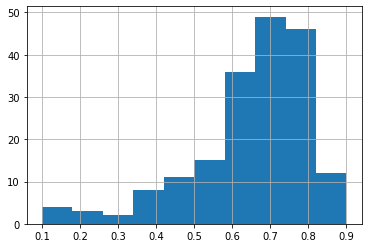

In [5]:
pd.Series(triazines.target).hist()
plt.savefig(folder /'images'/ 'triazine_bar.png')

In [6]:
triazines.data.shape

(186, 60)

# Ridege Regression

In [7]:
X_train, X_test, y_train, y_test = train_test_split(triazines.data, triazines.target, random_state=0)

In [12]:
np.logspace(-3, 3, 13)

array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])

In [16]:
param_grid = {'alpha': np.logspace(-3, 3, 13)}

grid = GridSearchCV(Ridge(), param_grid, cv = 5,return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])},
             return_train_score=True)

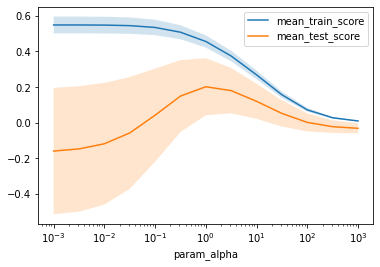

In [18]:
import pandas as pd
results = pd.DataFrame(grid.cv_results_)
results.plot('param_alpha', 'mean_train_score')
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_train_score'] + results['std_train_score'],
                 results['mean_train_score'] - results['std_train_score'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_test_score'] + results['std_test_score'],
                 results['mean_test_score'] - results['std_test_score'], alpha=0.2)
plt.legend()
plt.xscale("log")
#plt.yscale("log")
plt.savefig(folder / "images/ridge_alpha_triazine.png")

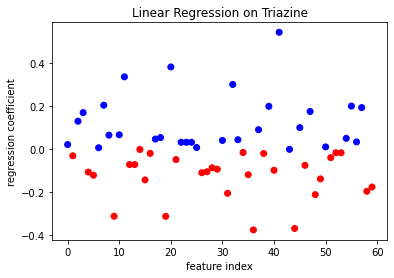

In [19]:
lr = LinearRegression().fit(X_train, y_train)
plt.scatter(range(X_train.shape[1]), lr.coef_, c=np.sign(lr.coef_), cmap='bwr_r')
plt.xlabel('feature index')
plt.ylabel('regression coefficient')
plt.title("Linear Regression on Triazine")
plt.savefig(folder / "images/lr_coefficients_large.png")

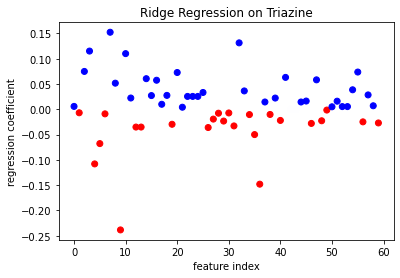

In [20]:
ridge = grid.best_estimator_
plt.scatter(range(X_train.shape[1]), ridge.coef_, c=np.sign(ridge.coef_), cmap='bwr_r')

plt.xlabel('feature index')
plt.ylabel('regression coefficient')
plt.title("Ridge Regression on Triazine")
plt.savefig(folder / "images/ridge_coefficients.png")

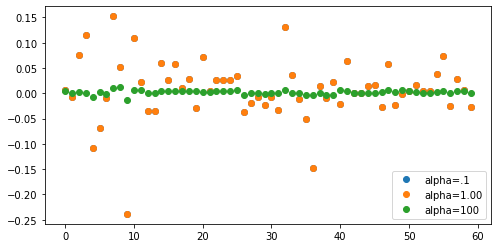

In [21]:
ridge100 = Ridge(alpha=100).fit(X_train, y_train)
ridge1 = Ridge(alpha=1).fit(X_train, y_train)
plt.figure(figsize=(8, 4))
plt.plot(ridge1.coef_, 'o', label="alpha=.1")
plt.plot(ridge.coef_, 'o', label=f"alpha={ridge.alpha:.2f}")
plt.plot(ridge100.coef_, 'o', label="alpha=100")
plt.legend()
plt.savefig(folder / "images/ridge_coefficients_alpha.png")

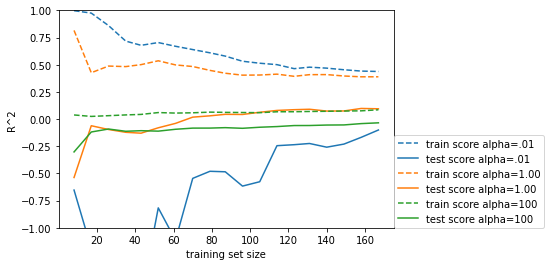

In [22]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(est, name):
    train_set_size, train_scores, test_scores = learning_curve(est, triazines.data, triazines.target, cv=10, train_sizes=np.linspace(0, 1, 20)[1:])
    test_mean = test_scores.mean(axis=1)
    train_mean = train_scores.mean(axis=1)
    line, = plt.plot(train_set_size, train_mean, linestyle="--", label="train score {}".format(name))
    plt.plot(train_set_size, test_mean, label="test score {}".format(name),
             c=line.get_color())
    
plot_learning_curve(Ridge(alpha=.01), "alpha=.01")
plot_learning_curve(Ridge(alpha=ridge.alpha), f"alpha={ridge.alpha:.2f}")
plot_learning_curve(Ridge(alpha=100), "alpha=100")

#plot_learning_curve(LinearRegression(), "lr")
plt.legend(loc=(1, 0))
plt.xlabel("training set size")
plt.ylabel("R^2")
plt.ylim(-1, 1)
plt.savefig(folder / "images/ridge_learning_curve.png")

# Lasso

In [25]:
def nonzero(est, X, y):
    return np.sum(est.coef_ != 0)

param_grid = {'alpha': np.logspace(-5, 0, 10)}

grid = GridSearchCV(Lasso(max_iter=20000), param_grid, cv=10, return_train_score=True,
                    scoring={'r2': 'r2', 'num_nonzero': nonzero}, refit='r2')
grid.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.342e-02, tolerance: 2.495e-04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


GridSearchCV(cv=10, estimator=Lasso(max_iter=20000),
             param_grid={'alpha': array([1.00000000e-05, 3.59381366e-05, 1.29154967e-04, 4.64158883e-04,
       1.66810054e-03, 5.99484250e-03, 2.15443469e-02, 7.74263683e-02,
       2.78255940e-01, 1.00000000e+00])},
             refit='r2', return_train_score=True,
             scoring={'num_nonzero': <function nonzero at 0x7fd5abf30e60>,
                      'r2': 'r2'})

In [26]:
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 0.0016681005372000592}
0.16305649781194234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


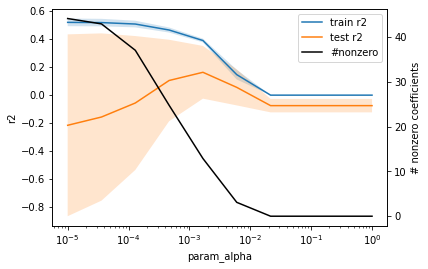

In [28]:
import pandas as pd
results = pd.DataFrame(grid.cv_results_)
a = results.plot('param_alpha', 'mean_train_r2', legend=False)
b = results.plot('param_alpha', 'mean_test_r2', ax=plt.gca(), legend=False)
plt.fill_between(results.param_alpha.astype(np.float64),
                 results['mean_train_r2'] + results['std_train_r2'],
                 results['mean_train_r2'] - results['std_train_r2'], alpha=0.2)
plt.fill_between(results.param_alpha.astype(np.float),
                 results['mean_test_r2'] + results['std_test_r2'],
                 results['mean_test_r2'] - results['std_test_r2'], alpha=0.2)
ax1 = plt.gca()
ax2 = ax1.twinx()
c = results.plot('param_alpha', 'mean_train_num_nonzero', ax=ax2, c='k', legend=False)
plt.legend(ax1.get_children()[2:4] + [c.get_children()[0]], ('train r2', 'test r2', '#nonzero'))
plt.xscale("log")
ax1.set_ylabel('r2')
ax2.set_ylabel('# nonzero coefficients')
plt.savefig(folder / "images/lasso_alpha_triazine.png")

# Elastic Net

In [29]:
X_train, X_test, y_train, y_test = train_test_split(triazines.data, triazines.target, random_state=42)

param_grid = {'alpha': np.logspace(-4, -1, 10), 'l1_ratio': [0.01, .1, .5, .8, .9, .95, .98, 1]}
print(param_grid)

{'alpha': array([0.0001    , 0.00021544, 0.00046416, 0.001     , 0.00215443,
       0.00464159, 0.01      , 0.02154435, 0.04641589, 0.1       ]), 'l1_ratio': [0.01, 0.1, 0.5, 0.8, 0.9, 0.95, 0.98, 1]}


In [31]:
from sklearn.linear_model import ElasticNet
grid = GridSearchCV(ElasticNet(max_iter=1e6), param_grid, cv=10, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=ElasticNet(max_iter=1000000.0),
             param_grid={'alpha': array([0.0001    , 0.00021544, 0.00046416, 0.001     , 0.00215443,
       0.00464159, 0.01      , 0.02154435, 0.04641589, 0.1       ]),
                         'l1_ratio': [0.01, 0.1, 0.5, 0.8, 0.9, 0.95, 0.98, 1]},
             return_train_score=True)

In [32]:
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 0.002154434690031882, 'l1_ratio': 0.8}
0.014830208917375997


In [33]:
grid.score(X_test, y_test)

0.24038992145809623

In [34]:
pd.DataFrame(grid.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'param_l1_ratio', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'split5_train_score',
       'split6_train_score', 'split7_train_score', 'split8_train_score',
       'split9_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [35]:
import pandas as pd
res = pd.pivot_table(pd.DataFrame(grid.cv_results_), values='mean_test_score', index='param_alpha', columns='param_l1_ratio')
pd.set_option("display.precision", 3)
res = res.set_index(res.index.values.round(4))

In [36]:
res

param_l1_ratio,0.01,0.10,0.50,0.80,0.90,0.95,0.98,1.00
1.000e-04,-0.389,-0.379,-3.426e-01,-0.295,-0.282,-0.275,-0.267,-2.651e-01
2.000e-04,-0.334,-0.320,-2.445e-01,-0.192,-0.179,-0.172,-0.168,-1.654e-01
5.000e-04,-0.271,-0.248,-1.453e-01,-0.090,-0.073,-0.066,-0.063,-6.135e-02
1.000e-03,-0.212,-0.180,-5.861e-02,-0.018,-0.008,-0.004,-0.002,-2.750e-04
2.200e-03,-0.158,-0.115,9.044e-04,0.015,0.008,0.004,0.002,-2.701e-04
4.600e-03,-0.112,-0.067,-1.911e-02,-0.074,-0.088,-0.093,-0.097,-9.954e-02
1.000e-02,-0.079,-0.036,-1.154e-01,-0.146,-0.150,-0.152,-0.154,-1.558e-01
2.150e-02,-0.062,-0.046,-1.627e-01,-0.181,-0.181,-0.181,-0.181,-1.814e-01
4.640e-02,-0.061,-0.127,-1.814e-01,-0.181,-0.181,-0.181,-0.181,-1.814e-01
1.000e-01,-0.082,-0.165,-1.814e-01,-0.181,-0.181,-0.181,-0.181,-1.814e-01


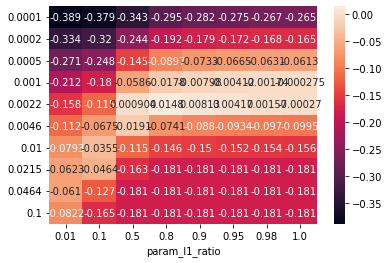

In [37]:
import seaborn as sns
sns.heatmap(res, annot=True, fmt=".3g")
plt.savefig(folder / "images/elasticnet_search.png")

# Logistic Regression

In [38]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [39]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [40]:
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_org)
X_test = scaler.transform(X_test_org)

In [41]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.118,0.278,0.300,0.147,0.242,0.079,...,25.38,17.33,184.60,2019.0,0.162,0.666,0.712,0.265,0.460,0.119
1,20.57,17.77,132.90,1326.0,0.085,0.079,0.087,0.070,0.181,0.057,...,24.99,23.41,158.80,1956.0,0.124,0.187,0.242,0.186,0.275,0.089
2,19.69,21.25,130.00,1203.0,0.110,0.160,0.197,0.128,0.207,0.060,...,23.57,25.53,152.50,1709.0,0.144,0.424,0.450,0.243,0.361,0.088
3,11.42,20.38,77.58,386.1,0.142,0.284,0.241,0.105,0.260,0.097,...,14.91,26.50,98.87,567.7,0.210,0.866,0.687,0.258,0.664,0.173
4,20.29,14.34,135.10,1297.0,0.100,0.133,0.198,0.104,0.181,0.059,...,22.54,16.67,152.20,1575.0,0.137,0.205,0.400,0.163,0.236,0.077


In [42]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [43]:
y.sum()/len(y)

0.6274165202108963

In [44]:
from sklearn.linear_model import LogisticRegression

c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_score_l1 = []
train_score_l2 = []
test_score_l1 = []
test_score_l2 = []

for c in c_range:
    log_l1 = LogisticRegression(penalty = 'l1', C = c, solver = 'saga', max_iter =10000)
    log_l2 = LogisticRegression(penalty = 'l2', C = c, max_iter =10000)
    log_l1.fit(X_train, y_train)
    log_l2.fit(X_train, y_train)
    train_score_l1.append(log_l1.score(X_train, y_train))
    train_score_l2.append(log_l2.score(X_train, y_train))
    test_score_l1.append(log_l1.score(X_test, y_test))
    test_score_l2.append(log_l2.score(X_test, y_test))

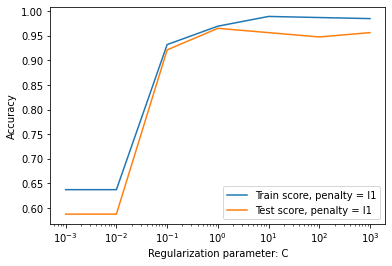

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(c_range, train_score_l1, label = 'Train score, penalty = l1')
plt.plot(c_range, test_score_l1, label = 'Test score, penalty = l1')
#plt.plot(c_range, train_score_l2, label = 'Train score, penalty = l2')
#plt.plot(c_range, test_score_l2, label = 'Test score, penalty = l2')
plt.legend()
plt.xlabel('Regularization parameter: C')
plt.ylabel('Accuracy')
plt.xscale('log')